# SVM: Version 3

## SVM with PCA and Heuristic-Based color thresholding

In [1]:
import cv2
import os
import glob
import time
import mlflow
import random
import shutil
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

In [2]:
TRAIN_DIR = "../data/train"
CLASS_FOLDERS = ["Class A", "Class B", "Class C", "Class D"]
ML_FLOW_DIRECTORY = "SVM_Logs"

In [3]:
mlflow.set_tracking_uri(ML_FLOW_DIRECTORY)
mlflow.set_experiment("SVM_PCA_heuristic_color_thresholding")

<Experiment: artifact_location='/Users/jacob/Code/Monkey-Business/SVM/SVM_Logs/725068244323799849', creation_time=1701930039088, experiment_id='725068244323799849', last_update_time=1701930039088, lifecycle_stage='active', name='SVM_PCA_heuristic_color_thresholding', tags={}>

In [4]:
pca_components = [40 * 40, 45 * 45, 50 * 50]
C_values = [0.1, 1, 10]
kernel_types = ["linear", "rbf"]
gamma_values = ["scale", "auto"]

In [5]:
hyperparameter_combinations = list(
    itertools.product(pca_components, C_values, kernel_types, gamma_values)
)
print(
    f"Total number of hyperparameter combinations: {len(hyperparameter_combinations)}"
)

Total number of hyperparameter combinations: 36


In [6]:
pca_models_dict = {}

In [7]:
def train_with_params(pca_components, C, kernel, gamma, train_images, train_labels):
    # Check if PCA model for pca_components already exists
    if pca_components in pca_models_dict:
        pca = pca_models_dict[pca_components]
        print(f"Using existing PCA model for {pca_components} components")
    else:
        # Apply PCA
        pca = PCA(n_components=pca_components)
        pca.fit(train_images)
        pca_models_dict[pca_components] = pca

    # Transform images with PCA
    train_images_pca = pca.transform(train_images)

    with mlflow.start_run() as run:
        start_time = time.time()

        # Initialize SVM model
        svm_model = svm.SVC(
            C=C, kernel=kernel, gamma=gamma, class_weight="balanced", verbose=True
        )

        # Perform cross-validation
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scoring = {
            "f1_weighted": make_scorer(f1_score, average="weighted"),
            "accuracy": "accuracy",
            "precision": make_scorer(precision_score, average="weighted"),
            "recall": make_scorer(recall_score, average="weighted"),
        }
        cv_results = cross_validate(
            svm_model,
            train_images_pca,
            train_labels,
            cv=skf,
            scoring=scoring,
            verbose=2,
        )

        # Log hyperparameters and metrics
        mlflow.log_params(
            {"pca_components": pca_components, "C": C, "kernel": kernel, "gamma": gamma}
        )
        mlflow.log_metrics(
            {
                "mean_f1_weighted": cv_results["test_f1_weighted"].mean(),
                "mean_accuracy": cv_results["test_accuracy"].mean(),
                "mean_precision": cv_results["test_precision"].mean(),
                "mean_recall": cv_results["test_recall"].mean(),
            }
        )
        end_time = time.time()
        duration = end_time - start_time
        param_details = f"PCA={pca_components}, C={C}, kernel={kernel}, gamma={gamma}"
        duration_details = f"Training duration for {param_details}: {duration} seconds"
        print(duration_details)
        run_id = run.info.run_id
        return run_id

In [9]:
def heuristic_color_thresholding(image_path):
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([80, 255, 255])
    lower_brown = np.array([10, 60, 60])
    upper_brown = np.array([30, 255, 200])

    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_green = cv2.inRange(hsv, lower_green, upper_green)
    mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)
    final_mask = cv2.bitwise_or(mask_yellow, mask_green)
    final_mask = cv2.bitwise_or(final_mask, mask_brown)
    result = cv2.bitwise_and(image, image, mask=final_mask)

    return result

In [10]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_folder in CLASS_FOLDERS:
        start_time = time.time()
        class_path = os.path.join(folder, class_folder)
        image_files = glob.glob(os.path.join(class_path, "*.png"))
        for img_file in image_files:
            processed_image = heuristic_color_thresholding(img_file)
            flattened_image = processed_image.flatten()
            images.append(flattened_image)
            labels.append(class_folder)
        end_time = time.time()
        duration = end_time - start_time
        print(f"Processing {class_folder} took {duration} seconds")
    return np.array(images), np.array(labels)

In [11]:
train_images, train_labels = load_images_from_folder(TRAIN_DIR)

Processing Class A took 1.8723907470703125 seconds
Processing Class B took 1.0526981353759766 seconds
Processing Class C took 0.7072510719299316 seconds
Processing Class D took 0.861295223236084 seconds


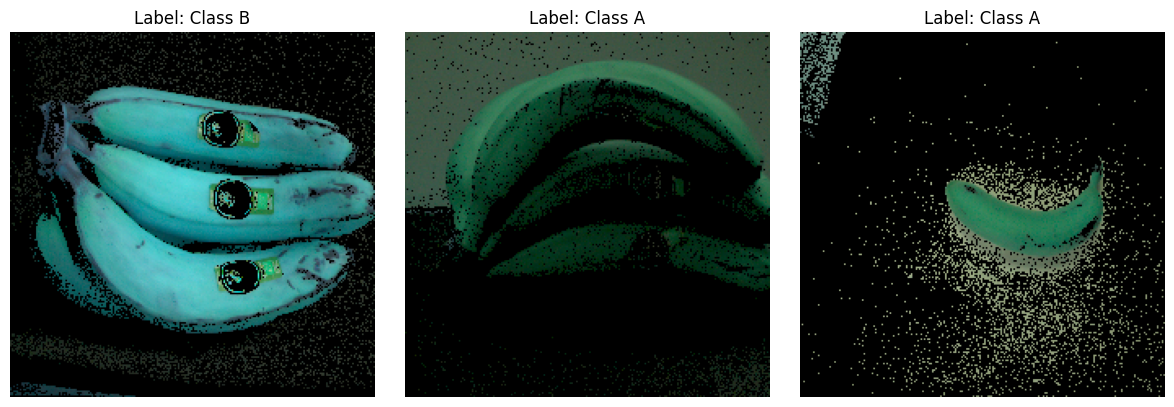

In [12]:
random_indices = random.sample(range(len(train_images)), 3)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, idx in enumerate(random_indices):
    image = train_images[idx].reshape(
        224, 224, 3
    )
    label = train_labels[idx]

    axs[i].imshow(image)
    axs[i].set_title(f"Label: {label}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [12]:
print(
    f"Shape of train_images: {train_images.shape}, Shape of train_labels: {train_labels.shape}"
)

Shape of train_images: (2796, 150528), Shape of train_labels: (2796,)


In [13]:
run_ids = []

for params in hyperparameter_combinations:
    pca_components, C, kernel, gamma = params
    run_id = train_with_params(
        pca_components, C, kernel, gamma, train_images, train_labels
    )
    run_ids.append(run_id)

[LibSVM]...*..*
optimization finished, #iter = 5460
obj = -0.000005, rho = 0.793179
nSV = 429, nBSV = 0
*.*
optimization finished, #iter = 1198
obj = -0.000001, rho = -0.252242
nSV = 210, nBSV = 0
.*
optimization finished, #iter = 1866
obj = -0.000001, rho = -0.202404
nSV = 268, nBSV = 0
....*.*
optimization finished, #iter = 4303
obj = -0.000002, rho = -0.945566
nSV = 388, nBSV = 0
...*.*
optimization finished, #iter = 3580
obj = -0.000002, rho = -0.817248
nSV = 391, nBSV = 0
...*.*
optimization finished, #iter = 3313
obj = -0.000002, rho = -0.057044
nSV = 378, nBSV = 0
Total nSV = 1200
[CV] END .................................................... total time=   2.6s
[LibSVM]...*..*
optimization finished, #iter = 5067
obj = -0.000004, rho = 0.698972
nSV = 428, nBSV = 0
*.*
optimization finished, #iter = 1268
obj = -0.000000, rho = -0.257093
nSV = 225, nBSV = 0
.*
optimization finished, #iter = 1903
obj = -0.000001, rho = -0.379932
nSV = 291, nBSV = 0
...*.*
optimization finished, #iter

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.7s
[LibSVM].*
optimization finished, #iter = 1194
obj = -89.260346, rho = 0.892874
nSV = 1197, nBSV = 1194
.
*
optimization finished, #iter = 1058
obj = -88.112835, rho = 0.843624
nSV = 1060, nBSV = 762
.*
optimization finished, #iter = 1130
obj = -88.797951, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.060397, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.598001, rho = -0.843624
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.7s
[LibSVM].*
optimization finished, #iter = 1196
obj = -89.275306, rho = 0.892874
nSV = 1197, nBSV = 1196
.*
optimization finished, #iter = 1059
obj = -88.103341, rho = 0.687248
nSV = 1060, nBSV = 1059
.*
optimization finished, #iter = 1130
obj = -88.812910, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.035944, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.573548, rho = -0.687248
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.6s
Training duration for PCA=1600, C=0.1, kernel=rbf, gamma=auto: 16.971483945846558 seconds
Using existing PCA model for 1600 components
[LibSVM]...*..*
optimization finished, #iter = 5460
obj = -0.000005, rho = 0.793179
nSV = 429, nBSV = 0
*.*
optimization finished, #iter = 1198
obj = -0.000001, rho = -0.252242
nSV = 210, nBSV = 0
.*
optimization finished, #iter = 1866
obj = -0.000001, rho = -0.202404
nSV = 268, nBSV = 0
....*.*
optimization finished, #iter = 4303
obj = -0.000002, rho = -0.945566
nSV = 388, nBSV = 0
...*.*
optimization finished, #iter = 3580
obj = -0.000002, rho = -0.817248
nSV = 391, nBSV = 0
...*.*
optimization finished, #iter = 3313
obj = -0.000002, rho = -0.057044
nSV = 378, nBSV = 0
Total nSV = 1200
[CV] END .................................................... total time=   2.5s
[LibSVM]...*..*
optimization finished, #iter = 5067
obj = -0.000004, rho = 0.698972
nSV = 428, nBSV = 0
*.*


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.6s
[LibSVM].*
optimization finished, #iter = 1666
obj = -538.248782, rho = -0.067917
nSV = 1197, nBSV = 752
.*.*
optimization finished, #iter = 2733
obj = -427.651130, rho = -0.435071
nSV = 1055, nBSV = 0
.*
optimization finished, #iter = 1543
obj = -493.181068, rho = -0.259741
nSV = 1130, nBSV = 752
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.6s
[LibSVM].*
optimization finished, #iter = 1492
obj = -539.573810, rho = -0.070589
nSV = 1197, nBSV = 760
..*
optimization finished, #iter = 2463
obj = -427.253254, rho = -0.438563
nSV = 1058, nBSV = 0
.*
optimization finished, #iter = 1691
obj = -494.124509, rho = -0.389316
nSV = 1130, nBSV = 521
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.6s
Training duration for PCA=1600, C=1, kernel=rbf, gamma=auto: 16.874788761138916 seconds
Using existing PCA model for 1600 components
[LibSVM]...*..*
optimization finished, #iter = 5460
obj = -0.000005, rho = 0.793179
nSV = 429, nBSV = 0
*.*
optimization finished, #iter = 1198
obj = -0.000001, rho = -0.252242
nSV = 210, nBSV = 0
.*
optimization finished, #iter = 1866
obj = -0.000001, rho = -0.202404
nSV = 268, nBSV = 0
....*.*
optimization finished, #iter = 4303
obj = -0.000002, rho = -0.945566
nSV = 388, nBSV = 0
...*.*
optimization finished, #iter = 3580
obj = -0.000002, rho = -0.817248
nSV = 391, nBSV = 0
...*.*
optimization finished, #iter = 3313
obj = -0.000002, rho = -0.057044
nSV = 378, nBSV = 0
Total nSV = 1200
[CV] END .................................................... total time=   2.5s
[LibSVM]...*..*
optimization finished, #iter = 5067
obj = -0.000004, rho = 0.698972
nSV = 428, nBSV = 0
*.*
op

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.7s
[LibSVM]..*.*
optimization finished, #iter = 3801
obj = -552.508255, rho = -0.270134
nSV = 1192, nBSV = 0
.*.*
optimization finished, #iter = 2946
obj = -427.651059, rho = -0.435071
nSV = 1055, nBSV = 0
..*.*
optimization finished, #iter = 3419
obj = -495.246184, rho = -0.345778
nSV = 1125, nBSV = 0
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1858


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.7s
[LibSVM]..*.*
optimization finished, #iter = 3849
obj = -553.570175, rho = -0.272575
nSV = 1196, nBSV = 0
.*.*
optimization finished, #iter = 2711
obj = -427.253267, rho = -0.438563
nSV = 1058, nBSV = 0
..*.*
optimization finished, #iter = 3629
obj = -496.099070, rho = -0.348096
nSV = 1129, nBSV = 0
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1861


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.5s
Training duration for PCA=1600, C=10, kernel=rbf, gamma=auto: 16.944263219833374 seconds
[LibSVM]..*..*
optimization finished, #iter = 4316
obj = -0.000003, rho = 0.682827
nSV = 494, nBSV = 0
*.*
optimization finished, #iter = 1099
obj = -0.000000, rho = -0.245354
nSV = 233, nBSV = 0
.*
optimization finished, #iter = 1692
obj = -0.000001, rho = -0.195550
nSV = 310, nBSV = 0
...*.*
optimization finished, #iter = 3169
obj = -0.000002, rho = -0.841212
nSV = 427, nBSV = 0
..*.*
optimization finished, #iter = 2960
obj = -0.000002, rho = -0.705133
nSV = 456, nBSV = 0
..*.*
optimization finished, #iter = 2512
obj = -0.000001, rho = 0.029997
nSV = 418, nBSV = 0
Total nSV = 1284
[CV] END .................................................... total time=   3.6s
[LibSVM]..*.*
optimization finished, #iter = 3616
obj = -0.000003, rho = 0.589701
nSV = 475, nBSV = 0
*.*
optimization finished, #iter = 1132
obj = -0.000000, 

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.2s
[LibSVM].*
optimization finished, #iter = 1194
obj = -89.260346, rho = 0.892874
nSV = 1197, nBSV = 1194
.
*
optimization finished, #iter = 1058
obj = -88.112835, rho = 0.843624
nSV = 1060, nBSV = 762
.*
optimization finished, #iter = 1130
obj = -88.797951, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.060397, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.598001, rho = -0.843624
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.1s
[LibSVM].*
optimization finished, #iter = 1196
obj = -89.275306, rho = 0.892874
nSV = 1197, nBSV = 1196
.*
optimization finished, #iter = 1059
obj = -88.103341, rho = 0.687248
nSV = 1060, nBSV = 1059
.*
optimization finished, #iter = 1130
obj = -88.812910, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.035944, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.573548, rho = -0.687248
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.1s
Training duration for PCA=2025, C=0.1, kernel=rbf, gamma=auto: 21.433531999588013 seconds
Using existing PCA model for 2025 components
[LibSVM]..*..*
optimization finished, #iter = 4316
obj = -0.000003, rho = 0.682827
nSV = 494, nBSV = 0
*.*
optimization finished, #iter = 1099
obj = -0.000000, rho = -0.245354
nSV = 233, nBSV = 0
.*
optimization finished, #iter = 1692
obj = -0.000001, rho = -0.195550
nSV = 310, nBSV = 0
...*.*
optimization finished, #iter = 3169
obj = -0.000002, rho = -0.841212
nSV = 427, nBSV = 0
..*.*
optimization finished, #iter = 2960
obj = -0.000002, rho = -0.705133
nSV = 456, nBSV = 0
..*.*
optimization finished, #iter = 2512
obj = -0.000001, rho = 0.029997
nSV = 418, nBSV = 0
Total nSV = 1284
[CV] END .................................................... total time=   3.6s
[LibSVM]..*.*
optimization finished, #iter = 3616
obj = -0.000003, rho = 0.589701
nSV = 475, nBSV = 0
*.*
optimiz

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.2s
[LibSVM].*
optimization finished, #iter = 1666
obj = -538.248782, rho = -0.067917
nSV = 1197, nBSV = 752
.*.*
optimization finished, #iter = 2733
obj = -427.651130, rho = -0.435071
nSV = 1055, nBSV = 0
.*
optimization finished, #iter = 1543
obj = -493.181068, rho = -0.259741
nSV = 1130, nBSV = 752
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.0s
[LibSVM].*
optimization finished, #iter = 1492
obj = -539.573810, rho = -0.070589
nSV = 1197, nBSV = 760
..*
optimization finished, #iter = 2463
obj = -427.253254, rho = -0.438563
nSV = 1058, nBSV = 0
.*
optimization finished, #iter = 1691
obj = -494.124509, rho = -0.389316
nSV = 1130, nBSV = 521
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.0s
Training duration for PCA=2025, C=1, kernel=rbf, gamma=auto: 21.220324993133545 seconds
Using existing PCA model for 2025 components
[LibSVM]..*..*
optimization finished, #iter = 4316
obj = -0.000003, rho = 0.682827
nSV = 494, nBSV = 0
*.*
optimization finished, #iter = 1099
obj = -0.000000, rho = -0.245354
nSV = 233, nBSV = 0
.*
optimization finished, #iter = 1692
obj = -0.000001, rho = -0.195550
nSV = 310, nBSV = 0
...*.*
optimization finished, #iter = 3169
obj = -0.000002, rho = -0.841212
nSV = 427, nBSV = 0
..*.*
optimization finished, #iter = 2960
obj = -0.000002, rho = -0.705133
nSV = 456, nBSV = 0
..*.*
optimization finished, #iter = 2512
obj = -0.000001, rho = 0.029997
nSV = 418, nBSV = 0
Total nSV = 1284
[CV] END .................................................... total time=   3.6s
[LibSVM]..*.*
optimization finished, #iter = 3616
obj = -0.000003, rho = 0.589701
nSV = 475, nBSV = 0
*.*
optimizat

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.2s
[LibSVM]..*.*
optimization finished, #iter = 3801
obj = -552.508255, rho = -0.270134
nSV = 1192, nBSV = 0
.*.*
optimization finished, #iter = 2946
obj = -427.651059, rho = -0.435071
nSV = 1055, nBSV = 0
..*.*
optimization finished, #iter = 3419
obj = -495.246184, rho = -0.345778
nSV = 1125, nBSV = 0
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1858


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.0s
[LibSVM]..*.*
optimization finished, #iter = 3849
obj = -553.570175, rho = -0.272575
nSV = 1196, nBSV = 0
.*.*
optimization finished, #iter = 2711
obj = -427.253267, rho = -0.438563
nSV = 1058, nBSV = 0
..*.*
optimization finished, #iter = 3629
obj = -496.099070, rho = -0.348096
nSV = 1129, nBSV = 0
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1861


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.1s
Training duration for PCA=2025, C=10, kernel=rbf, gamma=auto: 21.240864992141724 seconds
[LibSVM]..*.*
optimization finished, #iter = 3207
obj = -0.000002, rho = 0.606467
nSV = 551, nBSV = 0
*.*
optimization finished, #iter = 1016
obj = -0.000000, rho = -0.232999
nSV = 288, nBSV = 0
.*
optimization finished, #iter = 1506
obj = -0.000001, rho = -0.156949
nSV = 368, nBSV = 0
...*
optimization finished, #iter = 2843
obj = -0.000001, rho = -0.765990
nSV = 495, nBSV = 0
..*.*
optimization finished, #iter = 2506
obj = -0.000001, rho = -0.645169
nSV = 514, nBSV = 0
..*.*
optimization finished, #iter = 2101
obj = -0.000001, rho = 0.073528
nSV = 453, nBSV = 0
Total nSV = 1382
[CV] END .................................................... total time=   4.7s
[LibSVM]..*.*
optimization finished, #iter = 3100
obj = -0.000002, rho = 0.524276
nSV = 542, nBSV = 0
*.*
optimization finished, #iter = 1060
obj = -0.000000, rho

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.8s
[LibSVM].*
optimization finished, #iter = 1194
obj = -89.260346, rho = 0.892874
nSV = 1197, nBSV = 1194
.
*
optimization finished, #iter = 1058
obj = -88.112835, rho = 0.843624
nSV = 1060, nBSV = 762
.*
optimization finished, #iter = 1130
obj = -88.797951, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.060397, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.598001, rho = -0.843624
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.7s
[LibSVM].*
optimization finished, #iter = 1196
obj = -89.275306, rho = 0.892874
nSV = 1197, nBSV = 1196
.*
optimization finished, #iter = 1059
obj = -88.103341, rho = 0.687248
nSV = 1060, nBSV = 1059
.*
optimization finished, #iter = 1130
obj = -88.812910, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.035944, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.573548, rho = -0.687248
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.8s
Training duration for PCA=2500, C=0.1, kernel=rbf, gamma=auto: 26.289655208587646 seconds
Using existing PCA model for 2500 components
[LibSVM]..*.*
optimization finished, #iter = 3207
obj = -0.000002, rho = 0.606467
nSV = 551, nBSV = 0
*.*
optimization finished, #iter = 1016
obj = -0.000000, rho = -0.232999
nSV = 288, nBSV = 0
.*
optimization finished, #iter = 1506
obj = -0.000001, rho = -0.156949
nSV = 368, nBSV = 0
...*
optimization finished, #iter = 2843
obj = -0.000001, rho = -0.765990
nSV = 495, nBSV = 0
..*.*
optimization finished, #iter = 2506
obj = -0.000001, rho = -0.645169
nSV = 514, nBSV = 0
..*.*
optimization finished, #iter = 2101
obj = -0.000001, rho = 0.073528
nSV = 453, nBSV = 0
Total nSV = 1382
[CV] END .................................................... total time=   4.6s
[LibSVM]..*.*
optimization finished, #iter = 3100
obj = -0.000002, rho = 0.524276
nSV = 542, nBSV = 0
*.*
optimizati

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.7s
[LibSVM].*
optimization finished, #iter = 1666
obj = -538.248782, rho = -0.067917
nSV = 1197, nBSV = 752
.*.*
optimization finished, #iter = 2733
obj = -427.651130, rho = -0.435071
nSV = 1055, nBSV = 0
.*
optimization finished, #iter = 1543
obj = -493.181068, rho = -0.259741
nSV = 1130, nBSV = 752
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.7s
[LibSVM].*
optimization finished, #iter = 1492
obj = -539.573810, rho = -0.070589
nSV = 1197, nBSV = 760
..*
optimization finished, #iter = 2463
obj = -427.253254, rho = -0.438563
nSV = 1058, nBSV = 0
.*
optimization finished, #iter = 1691
obj = -494.124509, rho = -0.389316
nSV = 1130, nBSV = 521
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.6s
Training duration for PCA=2500, C=1, kernel=rbf, gamma=auto: 26.03443717956543 seconds
Using existing PCA model for 2500 components
[LibSVM]..*.*
optimization finished, #iter = 3207
obj = -0.000002, rho = 0.606467
nSV = 551, nBSV = 0
*.*
optimization finished, #iter = 1016
obj = -0.000000, rho = -0.232999
nSV = 288, nBSV = 0
.*
optimization finished, #iter = 1506
obj = -0.000001, rho = -0.156949
nSV = 368, nBSV = 0
...*
optimization finished, #iter = 2843
obj = -0.000001, rho = -0.765990
nSV = 495, nBSV = 0
..*.*
optimization finished, #iter = 2506
obj = -0.000001, rho = -0.645169
nSV = 514, nBSV = 0
..*.*
optimization finished, #iter = 2101
obj = -0.000001, rho = 0.073528
nSV = 453, nBSV = 0
Total nSV = 1382
[CV] END .................................................... total time=   4.7s
[LibSVM]..*.*
optimization finished, #iter = 3100
obj = -0.000002, rho = 0.524276
nSV = 542, nBSV = 0
*.*
optimization 

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.8s
[LibSVM]..*.*
optimization finished, #iter = 3801
obj = -552.508255, rho = -0.270134
nSV = 1192, nBSV = 0
.*.*
optimization finished, #iter = 2946
obj = -427.651059, rho = -0.435071
nSV = 1055, nBSV = 0
..*.*
optimization finished, #iter = 3419
obj = -495.246184, rho = -0.345778
nSV = 1125, nBSV = 0
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1858


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.8s
[LibSVM]..*.*
optimization finished, #iter = 3849
obj = -553.570175, rho = -0.272575
nSV = 1196, nBSV = 0
.*.*
optimization finished, #iter = 2711
obj = -427.253267, rho = -0.438563
nSV = 1058, nBSV = 0
..*.*
optimization finished, #iter = 3629
obj = -496.099070, rho = -0.348096
nSV = 1129, nBSV = 0
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1861
[CV] END .................................................... total time=   9.0s
Training duration for PCA=2500, C=10, kernel=rbf, gamma=auto: 26.652085065841675 seconds


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
run_metrics = {}

for run_id in run_ids:
    client = mlflow.tracking.MlflowClient(ML_FLOW_DIRECTORY)
    run = client.get_run(run_id)
    metrics = run.data.metrics
    run_metrics[run_id] = metrics

for run_id, metrics in run_metrics.items():
    print(f"Run ID: {run_id}")
    for metric, value in metrics.items():
        print(f"\t{metric}: {value}")

Run ID: 880325a203664a49b26f385e828e8d9a
	mean_f1_weighted: 0.7709596949649072
	mean_accuracy: 0.772889842632332
	mean_recall: 0.772889842632332
	mean_precision: 0.7704984181750968
Run ID: 6fd50341c5a94a7d8d647f6a4930fb42
	mean_f1_weighted: 0.7709596949649072
	mean_accuracy: 0.772889842632332
	mean_recall: 0.772889842632332
	mean_precision: 0.7704984181750968
Run ID: 7bdbce01131c4cd29112b966fc3e9d20
	mean_f1_weighted: 0.5508562954690585
	mean_accuracy: 0.5815450643776824
	mean_recall: 0.5815450643776824
	mean_precision: 0.6082632026754454
Run ID: 89ed5beb4f3c4f48adeb88c1b0724bc6
	mean_f1_weighted: 0.08033054698280266
	mean_accuracy: 0.22103004291845493
	mean_recall: 0.22103004291845493
	mean_precision: 0.04913288143086076
Run ID: 336206d63da14b46bcbd8f30f964a713
	mean_f1_weighted: 0.7709596949649072
	mean_accuracy: 0.772889842632332
	mean_recall: 0.772889842632332
	mean_precision: 0.7704984181750968
Run ID: 204a86ec54c24105aa2bac982e446b52
	mean_f1_weighted: 0.7709596949649072
	mean_ac

In [17]:
best_run_id = max(run_metrics, key=lambda x: run_metrics[x]["mean_f1_weighted"])
best_params = client.get_run(best_run_id).data.params
best_run_metrics = run_metrics[best_run_id]

print(f"\nBest Run ID: {best_run_id}")
print("Best Parameters:")
for key, value in best_params.items():
    print(f"\t{key}: {value}")

print("\nBest Run Metrics:")
for metric, value in best_run_metrics.items():
    print(f"\t{metric}: {value}")


Best Run ID: 70c67528ab4c40a9af491238eec96afa
Best Parameters:
	gamma: scale
	pca_components: 1600
	C: 10
	kernel: rbf

Best Run Metrics:
	mean_f1_weighted: 0.8192517945784673
	mean_accuracy: 0.8204577968526466
	mean_recall: 0.8204577968526466
	mean_precision: 0.8191830019961214
